In [1]:
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC 
from tools import columns_cat, columns_quant
# SMOTENC est une variante de SMOTE qui gère des datasets contenant à la fois des variables continues et catégorielles (ne s'applique pas à un dataset contenant uniquement des variables catégorielles).

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

In [3]:
df = df[columns_quant + columns_cat + ['is_display_clicked']]
df.shape

(1610494, 22)

In [4]:
df.isna().sum() # On regarde si certaines observations présentent des valeurs manquantes car la méthode SMOTE ne permet pas de les traiter.

contextid                                  0
campaignctrlast24h                         0
dayssincelastvisitdouble                   0
ltf_nbglobaldisplay_4w                     0
ltf_nbpartnerdisplayssincelastclick        0
ltf_nbpartnerdisplay_90d                   0
ltf_nbpartnerclick_90d                     0
ltf_nbpartnersales_90d                     0
nbdayssincelastclick                       0
nbdisplay_1hour                            0
nbdisplayglobalapprox_1d_sum_xdevice       0
display_size                               0
zonecostineuro                             0
display_env                                0
target_env                                 0
campaignscenario                           0
campaignvertical                          29
is_interstitial                         6911
device_type                                0
hour                                       0
weekday                                    0
is_display_clicked                         0
dtype: int

In [5]:
df = df.dropna() # On supprime les observations présentant des valeurs manquantes.
df.shape

(1603554, 22)

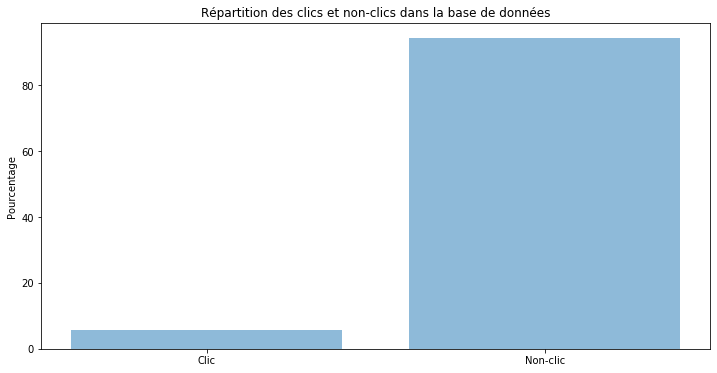

In [6]:
objects = ('Clic', 'Non-clic')
labels = np.arange(len(objects))
ratio = [(len(df[df['is_display_clicked']==1])/len(df))*100, (len(df[df['is_display_clicked']==0])/len(df))*100]

plt.figure(figsize=(12,6))
plt.bar(labels, ratio, align='center', alpha=0.5)
plt.xticks(labels, objects)
plt.ylabel('Pourcentage')
plt.title('Répartition des clics et non-clics dans la base de données')
plt.show()

Nous faisons face ici à un jeu de données extrêmement déséquilibré, au sein duquel la classe minoritaire (modalité 1 de la variable cible, associée au clic) représente à peine 6% des observations de la base. Les modèles précédemment appliqués à notre base, pour lesquels nous n'avons pas tenu compte de cette contrainte de déséquilibre des données, présentent une faible performance pour les métriques pertinentes d'un point de vue métier, à savoir ici le recall et le F1 Score. Le ré-échantillonnage est l’une des méthodes les plus régulièrement utilisées pour résoudre ce problème.

Dans le cadre de notre étude, nous allons sur-échantillonner les observations associées à la classe la moins prépondérante, ici les clics. Pour cela nous nous appuierons sur la méthode SMOTE (plus exactement SMOTENC afin de traiter les données catégorielles) ; SMOTE signifiant Synthetic Minority Over-Sampling Technique. Cette technique consiste à sélectionner une observation de la classe minoritaire et un nombre fixé de ses plus proches voisins. En fonction du ratio de clics désirés, la distance euclidienne entre les features de l'observation sélectionnée et un certain nombre de ses voisins sera calculée, puis multipliée par un nombre entre 0 et 1. Le résultat est ensuite ajouté à l'observation choisie et on obtient alors une nouvelle observation. Le processus est répété pour toutes les observations de la classe minoritaire. Cette méthode est ainsi plus sophistiquée qu'une simple répétition aléatoire d'observations. 

In [7]:
X = df[columns_quant + columns_cat]
y = df['is_display_clicked']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

In [9]:
seed = 42 # Graîne aléatoire pour la reproductibilité des résultats
sm = SMOTENC(categorical_features=[13,14,15,16,17,18,19,20], sampling_strategy=1, k_neighbors=5, random_state=seed)
# categorical_features : indices des variables catégorielles
# sampling_strategy : ratio désiré du nombre d'observations de la classe minoritaire sur le nombre d'observations de la classe majoritaire après rééchantillonnage. Ici, 1 signifie donc que l'on souhaite autant d'observations provenant des deux classes.
# k_neighbors : nombre de plus proches voisins utilisés pour construire les observations synthétiques. 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [10]:
df_train_res = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res)], axis=1)
df_train_res.columns = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro', 'display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday', 'is_display_clicked']

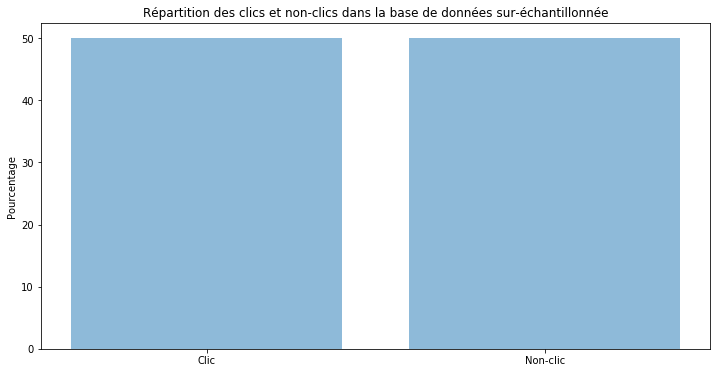

In [11]:
objects = ('Clic', 'Non-clic')
labels = np.arange(len(objects))
ratio = [(len(df_train_res[df_train_res['is_display_clicked']==1])/len(df_train_res))*100, (len(df_train_res[df_train_res['is_display_clicked']==0])/len(df_train_res))*100]

plt.figure(figsize=(12,6))
plt.bar(labels, ratio, align='center', alpha=0.5)
plt.xticks(labels, objects)
plt.ylabel('Pourcentage')
plt.title('Répartition des clics et non-clics dans la base de données sur-échantillonnée')
plt.show()

# On vérifie que l'on a bien 50% d'observations de chaque classe.

In [12]:
df_train_res.to_csv('data/df_train_res.csv', index=False)

In [13]:
df_test_res = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)
df_test_res.columns = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro', 'display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday', 'is_display_clicked']

In [14]:
df_test_res.to_csv('data/df_test_res.csv', index=False)

In [15]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:12:36
